## Spanish Translation: A/B testing

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. Therefore, they agreed to try a test where each country would have its own translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users written by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised because the test is negative. That is, it appears that the non-highly localized translation was doing better!

You are asked to:

- Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better.


- Explain why that might be happening. Are the localized translations really worse?


- If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and results can be trusted.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Load the test and user data

In [2]:
df_test = pd.read_csv('test_table.csv')

In [3]:
df_test.head(10)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0
7,527287,2015-12-03,Direct,Web,EN,NaN,Chrome,0,0
8,261625,2015-12-04,Direct,Mobile,ES,NaN,Android_App,0,1
9,10427,2015-12-04,Ads,Mobile,ES,Facebook,Android_App,0,0


### Description

- user_id: the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.

- date : when they came to the site for the first time since the test started

- source : marketing channel: Ads, SEO, Direct. Direct means everything except for ads and SEO, such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.

- device : device used by the user. It can be mobile or web

- browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish)

- ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn’t come via an ad, this field is NA

- browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera

- conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.

- test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.

In [4]:
df_user = pd.read_csv('user_table.csv')

In [5]:
df_user.head(10)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain
5,62371,M,29,Ecuador
6,987967,M,31,Spain
7,499510,F,29,Paraguay
8,364726,F,29,Colombia
9,572551,M,21,Bolivia


- user_id : the id of the user. It can be joined to user id in the other table
- sex : user sex: Male or Female
- age : user age (self-reported)
- country : user country based on ip address

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [7]:
df_test.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

In [8]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [9]:
df_user.isnull().sum()

user_id    0
sex        0
age        0
country    0
dtype: int64

In [10]:
print("test data points: ", df_test.shape)
print("user data points: ", df_user.shape)

test data points:  (453321, 9)
user data points:  (452867, 4)


More test data points than user points.

### User table left join Test table

In [11]:
df_combine = pd.merge(df_test, df_user, how='left', on=['user_id'])
df_combine.head(10)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico
7,527287,2015-12-03,Direct,Web,EN,NaN,Chrome,0,0,M,22.0,Spain
8,261625,2015-12-04,Direct,Mobile,ES,NaN,Android_App,0,1,M,31.0,Bolivia
9,10427,2015-12-04,Ads,Mobile,ES,Facebook,Android_App,0,0,F,33.0,Mexico


In [12]:
# check joined table with missing sex, age and country information

print("missing: ", df_combine[df_combine.age.isnull()].shape)
df_combine[df_combine.age.isnull()].head()

missing:  (454, 12)


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
819,657841,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0,NaN,NaN,NaN
1696,859340,2015-12-04,Direct,Mobile,EN,NaN,Android_App,0,0,NaN,NaN,NaN
1934,716487,2015-12-04,SEO,Mobile,ES,NaN,Android_App,0,0,NaN,NaN,NaN
2409,87209,2015-12-01,Direct,Web,ES,NaN,Chrome,0,0,NaN,NaN,NaN
2721,771642,2015-11-30,SEO,Mobile,ES,NaN,Android_App,0,0,NaN,NaN,NaN


## A/B testing the general case

In [13]:
# First A/B test to check test and control data for all other countries.

test = df_combine.loc[(df_combine.country != 'Spain') & (df_combine.test == 1)].conversion
control = df_combine.loc[(df_combine.country != 'Spain') & (df_combine.test == 0)].conversion

stat,pvalue = stats.ttest_ind(test, control, equal_var=False)

print("test conversion rate: ", test.mean())
print("control conversion rate: ", control.mean())
print(stat,pvalue)

test conversion rate:  0.043424713982118966
control conversion rate:  0.04833042316066309
-7.3939374121344805 1.4282994754055316e-13


The p-value has a tiny number, that means the Null Hypothesis should be rejected, the test and control has different means. The local translation is really worse than non-highly localized translation! Now I do A/B testing for each countries expect Spain. But this is not the whole story!

### Group by Countries

In [14]:
df_country = df_combine.groupby(['country'])['conversion'].mean().reset_index()
df_country = df_country.sort_values('conversion',ascending=False)
df_country

,country,conversion
14,Spain,0.079719
4,Costa Rica,0.053494
10,Nicaragua,0.053399
3,Colombia,0.051332
6,El Salvador,0.050765
9,Mexico,0.050341
13,Peru,0.050258
2,Chile,0.049704
16,Venezuela,0.049666
7,Guatemala,0.049653


It looks that Spain has the highest conversion rate. Let us visualize the results. 

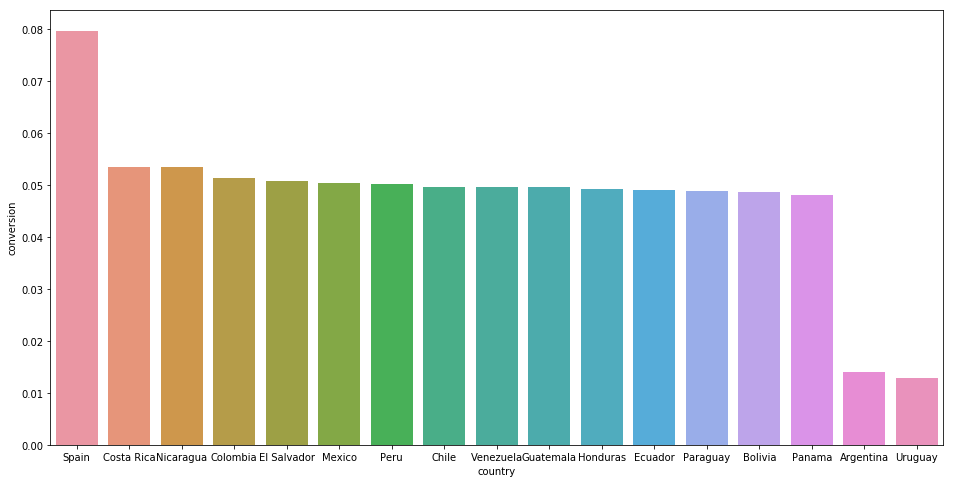

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='country',y='conversion',data=df_country,ax=ax)

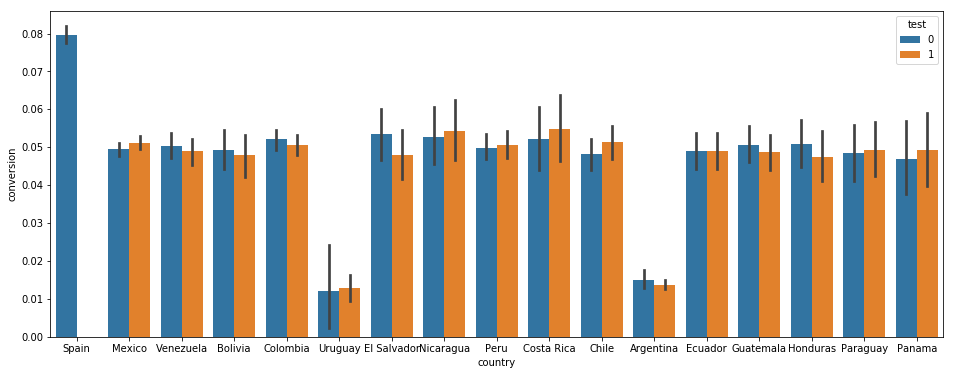

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='country', y='conversion', hue='test', data=df_combine, ax=ax)
plt.show()

In [17]:
df_combine.loc[(df_combine.country=='Spain') & (df_combine.test==1)]

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country


Spain does not have test data. So I do the first A/B test for test and control data for other countries.

In [18]:
countries = df_country.country.unique()

list_test = []
list_control = []
list_pvalues = []

for country in countries:
    if country != 'Spain':
        test = df_combine.loc[(df_combine.country == country) & (df_combine.test == 1)].conversion
        control = df_combine.loc[(df_combine.country == country) & (df_combine.test == 0)].conversion
        stat,pvalue = stats.ttest_ind(test, control, equal_var=False)

        #print(country)
        #print("test: ", test.mean())
        #print('control: ', control.mean())
        #print("pvalue: ", pvalue)
        
        list_test.append(test.mean())
        list_control.append(control.mean())
        list_pvalues.append(pvalue)

In [19]:
list_country = countries[1:]

In [20]:
df_ABtest1 = pd.DataFrame({
        'country':list_country,
        'test':list_test,
        'control':list_control,
        'pvalue':list_pvalues
    })

In [21]:
df_ABtest1['ratio']= df_ABtest1.test/df_ABtest1.control

In [22]:
df_ABtest1.sort_values('ratio',ascending = False)

,country,test,control,pvalue,ratio
15,Uruguay,0.012907,0.012048,0.879764,1.071256
6,Chile,0.051295,0.048107,0.302848,1.066266
13,Panama,0.049370,0.046796,0.705327,1.055021
0,Costa Rica,0.054738,0.052256,0.687876,1.047497
4,Mexico,0.051186,0.049495,0.165544,1.034179
1,Nicaragua,0.054177,0.052647,0.780400,1.029057
11,Paraguay,0.049229,0.048493,0.883697,1.015176
5,Peru,0.050604,0.049914,0.771953,1.013828
10,Ecuador,0.048988,0.049154,0.961512,0.996635
7,Venezuela,0.048978,0.050344,0.573702,0.972879


The pvalue shows that there is no difference between the test and the control for each country! This is important. 

### Remove Spain data and Groupby by Dates

In [23]:
df_combine = df_combine[df_combine.country != 'Spain']

In [24]:
df_combine.date.unique()

array(['2015-12-04', '2015-12-03', '2015-11-30', '2015-12-02',
       '2015-12-01'], dtype=object)

In [25]:
df_date = df_combine.groupby('date')['conversion'].mean().reset_index()
dates = df_combine.date.unique()
df_date

,date,conversion
0,2015-11-30,0.047343
1,2015-12-01,0.043649
2,2015-12-02,0.046233
3,2015-12-03,0.046381
4,2015-12-04,0.045132


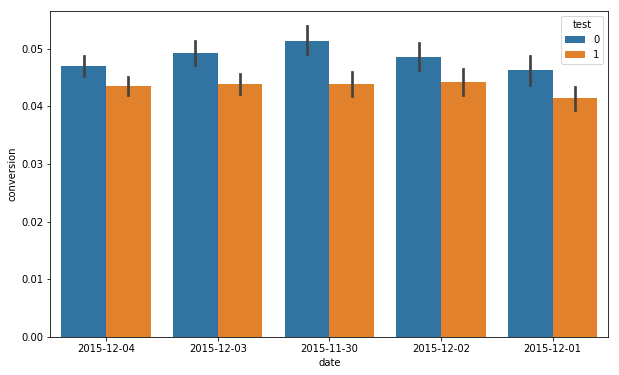

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='date', y='conversion', hue='test', data=df_combine, ax=ax)
plt.show()

In [27]:
test_converted = []
control_converted = []
list_pvalues = []

for date in dates:
    test = df_combine.loc[(df_combine.date == date) & (df_combine.test == 1)].conversion
    control = df_combine.loc[(df_combine.date == date) & (df_combine.test == 0)].conversion
    
    stat,pvalue = stats.ttest_ind(test, control, equal_var=False)
    test_converted.append(test.mean())
    control_converted.append(control.mean())
    list_pvalues.append(pvalue)

In [28]:
df_date['test_converted'] = test_converted 
df_date['control_converted'] = control_converted 
df_date['pvalues'] = list_pvalues
df_date['ratio'] = df_date['test_converted'] / df_date['control_converted']

In [29]:
df_date

,date,conversion,test_converted,control_converted,pvalues,ratio
0,2015-11-30,0.047343,0.043491,0.047043,0.002628,0.924486
1,2015-12-01,0.043649,0.043884,0.049284,0.000153,0.890439
2,2015-12-02,0.046233,0.043886,0.051378,0.000012,0.854179
3,2015-12-03,0.046381,0.044234,0.048550,0.010651,0.911090
4,2015-12-04,0.045132,0.041387,0.046287,0.002822,0.894141


### Group by Sources

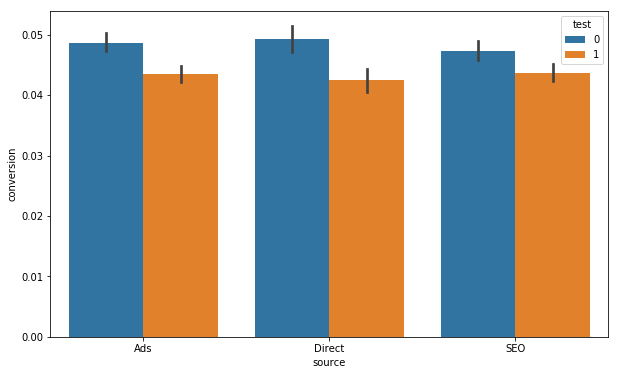

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='source', y='conversion', hue='test', data=df_combine, ax=ax)
plt.show()

In [31]:
df_source = df_combine.groupby('source')['conversion'].mean().reset_index()
sources = df_combine.source.unique()

test_converted = []
control_converted = []
list_pvalues = []

for source in sources:
    test = df_combine.loc[(df_combine.source == source) & (df_combine.test == 1)].conversion
    control = df_combine.loc[(df_combine.source == source) & (df_combine.test == 0)].conversion
    
    stat,pvalue = stats.ttest_ind(test, control, equal_var=False)
    test_converted.append(test.mean())
    control_converted.append(control.mean())
    list_pvalues.append(pvalue)
    
df_source['test_converted'] = test_converted 
df_source['control_converted'] = control_converted 
df_source['pvalues'] = list_pvalues
df_source['ratio'] = df_source['test_converted'] / df_source['control_converted']

df_source

,source,conversion,test_converted,control_converted,pvalues,ratio
0,Ads,0.045955,0.043546,0.048754,7.193895e-07,0.893175
1,Direct,0.045633,0.042489,0.049267,4.898604e-06,0.862422
2,SEO,0.045457,0.043770,0.047430,4.748800e-04,0.922839


### Group by Devices

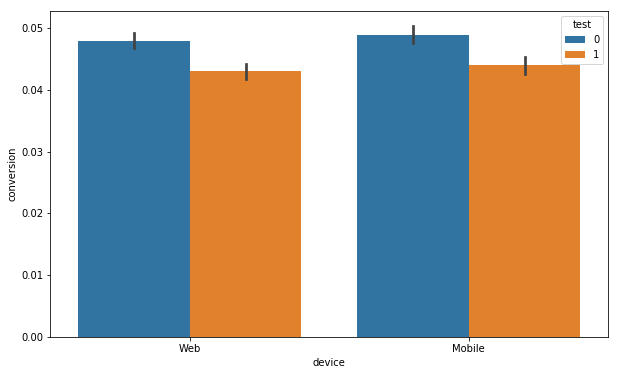

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='device', y='conversion', hue='test', data=df_combine, ax=ax)
plt.show()

In [33]:
df_device = df_combine.groupby('device')['conversion'].mean().reset_index()
devices = df_combine.device.unique()

test_converted = []
control_converted = []
list_pvalues = []

for device in devices:
    test = df_combine.loc[(df_combine.device == device) & (df_combine.test == 1)].conversion
    control = df_combine.loc[(df_combine.device == device) & (df_combine.test == 0)].conversion
    
    stat,pvalue = stats.ttest_ind(test, control, equal_var=False)
    test_converted.append(test.mean())
    control_converted.append(control.mean())
    list_pvalues.append(pvalue)
    
df_device['test_converted'] = test_converted 
df_device['control_converted'] = control_converted 
df_device['pvalues'] = list_pvalues
df_device['ratio'] = df_device['test_converted'] / df_device['control_converted']

df_device

,device,conversion,test_converted,control_converted,pvalues,ratio
0,Mobile,0.046239,0.042959,0.047914,2.284113e-08,0.896572
1,Web,0.045253,0.044003,0.048851,1.253595e-06,0.900771


### Group by Browsers

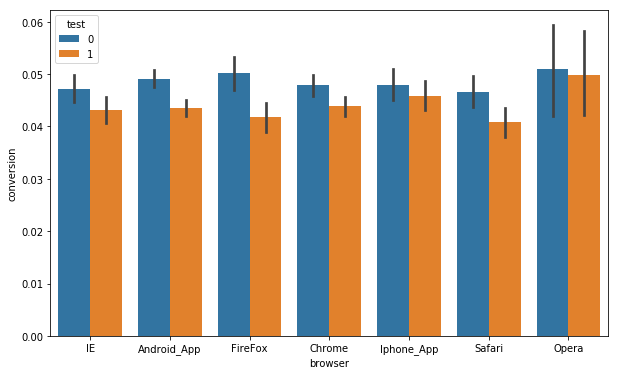

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='browser', y='conversion', hue='test', data=df_combine, ax=ax)
plt.show()

In [35]:
df_browser = df_combine.groupby('browser')['conversion'].mean().reset_index()
browsers = df_combine.browser.unique()

test_converted = []
control_converted = []
list_pvalues = []

for browser in browsers:
    test = df_combine.loc[(df_combine.browser == browser) & (df_combine.test == 1)].conversion
    control = df_combine.loc[(df_combine.browser == browser) & (df_combine.test == 0)].conversion
    
    stat,pvalue = stats.ttest_ind(test, control, equal_var=False)
    test_converted.append(test.mean())
    control_converted.append(control.mean())
    list_pvalues.append(pvalue)
    
df_browser['test_converted'] = test_converted 
df_browser['control_converted'] = control_converted 
df_browser['pvalues'] = list_pvalues
df_browser['ratio'] = df_browser['test_converted'] / df_browser['control_converted']

df_browser

,browser,conversion,test_converted,control_converted,pvalues,ratio
0,Android_App,0.046076,0.043052,0.047139,2.181403e-02,0.913283
1,Chrome,0.045691,0.043469,0.049130,6.758821e-07,0.884776
2,FireFox,0.045629,0.041697,0.050204,1.267372e-04,0.830544
3,IE,0.044952,0.043851,0.047858,4.194395e-03,0.916264
4,Iphone_App,0.046782,0.045793,0.047928,3.064244e-01,0.955459
5,Opera,0.050344,0.040795,0.046539,7.542105e-03,0.876584
6,Safari,0.043493,0.049879,0.050881,8.668824e-01,0.980295


## More details

This is following the solution in the book. Dummy the data and then do decision tree classification to test if the control and test data is randomly selected.

In [36]:
df_dummy = pd.get_dummies(df_combine)

In [37]:
pd.set_option('display.max_columns', None) 
df_dummy = df_dummy.dropna()
df_dummy

,user_id,conversion,test,age,date_2015-11-30,date_2015-12-01,date_2015-12-02,date_2015-12-03,date_2015-12-04,source_Ads,source_Direct,source_SEO,device_Mobile,device_Web,browser_language_EN,browser_language_ES,browser_language_Other,ads_channel_Bing,ads_channel_Facebook,ads_channel_Google,ads_channel_Other,ads_channel_Yahoo,browser_Android_App,browser_Chrome,browser_FireFox,browser_IE,browser_Iphone_App,browser_Opera,browser_Safari,sex_F,sex_M,country_Argentina,country_Bolivia,country_Chile,country_Colombia,country_Costa Rica,country_Ecuador,country_El Salvador,country_Guatemala,country_Honduras,country_Mexico,country_Nicaragua,country_Panama,country_Paraguay,country_Peru,country_Uruguay,country_Venezuela
1,497851,0,1,21.0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,290051,0,1,22.0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,548435,0,1,19.0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,540675,0,1,22.0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,863394,0,0,35.0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,261625,0,1,31.0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,10427,0,0,33.0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10,8343,1,0,37.0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11,73335,0,1,29.0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
13,234023,0,0,19.0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [38]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [39]:
X_train = df_dummy.drop(['test','conversion'],axis=1)
y_train = df_dummy.test

In [40]:
y_train.value_counts()

1    215774
0    185311
Name: test, dtype: int64

In [41]:
DT = DecisionTreeClassifier()
DT.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Users from Argentina and Uruguay are way more likely to be in test than control. 

In [42]:
list(X_train.columns)[2]

'date_2015-11-30'

In [43]:
importances = DT.feature_importances_

important_list = []
for i in np.argsort(importances)[::-1]:
    important_list.append(list(X_train.columns)[i])
    
np.array(important_list)

array(['user_id', 'age', 'country_Argentina', 'country_Mexico',
       'date_2015-12-04', 'date_2015-12-02', 'sex_F', 'sex_M',
       'date_2015-11-30', 'date_2015-12-03', 'date_2015-12-01',
       'ads_channel_Google', 'ads_channel_Facebook', 'browser_Chrome',
       'country_Colombia', 'browser_language_ES', 'browser_IE',
       'country_Venezuela', 'browser_language_EN', 'browser_FireFox',
       'source_SEO', 'country_Chile', 'source_Ads', 'browser_Android_App',
       'country_Guatemala', 'country_Peru', 'browser_Iphone_App',
       'country_Bolivia', 'country_Uruguay', 'country_El Salvador',
       'browser_language_Other', 'ads_channel_Yahoo', 'device_Web',
       'country_Paraguay', 'device_Mobile', 'ads_channel_Bing',
       'country_Costa Rica', 'browser_Opera', 'source_Direct',
       'country_Panama', 'country_Ecuador', 'country_Nicaragua',
       'ads_channel_Other', 'country_Honduras', 'browser_Safari'],
      dtype='<U22')

In [44]:
df_dummy.groupby('test')['country_Argentina','country_Mexico','country_Colombia','country_Venezuela'].mean()

,country_Argentina,country_Mexico,country_Colombia,country_Venezuela
test,,,,
0,0.050488,0.346493,0.146176,0.087145
1,0.173223,0.297881,0.125001,0.073711


In [45]:
df_dummy.groupby('test')['date_2015-12-04','date_2015-12-02'].mean()

,date_2015-12-04,date_2015-12-02
test,,
0,0.311390,0.155970
1,0.311391,0.155334


This means that test and control are not randomly selected. For example:

In [46]:
test = df_dummy[(df_dummy.country_Argentina == 0) 
                & (df_dummy.test == 1)].conversion

control = df_dummy[(df_dummy.country_Argentina == 0) 
                & (df_dummy.test == 0)].conversion
    
stat,pvalue = stats.ttest_ind(test, control, equal_var=False)
print(test.mean())
print(control.mean())
print(pvalue)

0.04963087944303996
0.05005825353073229
0.5588956781487642


After removing country_Argentina the A/B testing shows that local translation does not change too much!